This script is to visualize the priors/anchors of the SSD framework. The code comes with little documentation, but in essence it visualizes the priors for different feature maps of the SSD framework.
This way you can visualize where they are placed on the original image, how large they are and how many priors there are.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import sys
import torch
import numpy as np
import pathlib
path = pathlib.Path()
# Insert all modules a folder above
sys.path.insert(0, str(path.absolute().parent))
from ssd.config.defaults import cfg
from ssd.modeling.box_head.prior_box import PriorBox
from ssd.utils.box_utils import convert_locations_to_boxes
def plot_bbox(ax, box, color, circle=True):
    cx, cy, w, h = box
    cx *= cfg.INPUT.IMAGE_SIZE[1]
    cy *= cfg.INPUT.IMAGE_SIZE[0]
    w *= cfg.INPUT.IMAGE_SIZE[1]
    h *= cfg.INPUT.IMAGE_SIZE[0]
    x1, y1 = cx + w/2, cy + h/2
    x0, y0 = cx - w/2, cy - h/2
    if circle:
        ax.add_artist(matplotlib.patches.Ellipse([cx, cy], w,h, alpha=.1, color=color))
        plt.plot(cx, cy, f"o{color}")
    else:
        plt.plot([x0, x0, x1, x1, x0],[y0, y1, y1, y0, y0], f"{color}", alpha=.1)

In [4]:
config_path = "../configs/train_rdd2020_server.yaml"
cfg.merge_from_file(config_path)
PLOT_CIRCLE = True
# Set which priors we want to visualize
# 0 is the last layer
layer_to_visualize = 5
# Set which aspect ratio indices we want to visualize
aspect_ratio_indices = [2]

Prior box shape: torch.Size([8732, 4])
First prior example: tensor([0.0200, 0.0067, 0.0707, 0.0707])


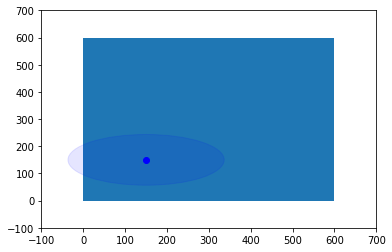

In [5]:
fig, ax = plt.subplots()
# Create prior box
prior_box = PriorBox(cfg)
priors = prior_box()
print("Prior box shape:", priors.shape)
# Prior boxes are saved such that all prior boxes at the first feature map is saved first, then all prios at the next (lower) feature map
print("First prior example:", priors[5])
locations = torch.zeros_like(priors)[None]
priors_as_location = convert_locations_to_boxes(locations, priors,cfg.MODEL.CENTER_VARIANCE, cfg.MODEL.SIZE_VARIANCE)[0]

# Set up our scene
plt.ylim([-100, cfg.INPUT.IMAGE_SIZE[0]+100])
plt.xlim([-100, cfg.INPUT.IMAGE_SIZE[1]+100])


def get_num_boxes_in_fmap(idx):
    boxes_per_location = cfg.MODEL.PRIORS.BOXES_PER_LOCATION[idx]
    feature_map_size = cfg.MODEL.PRIORS.FEATURE_MAPS[idx]
    return int(boxes_per_location * np.prod(feature_map_size))

offset = sum([get_num_boxes_in_fmap(prev_layer) for prev_layer in range(layer_to_visualize)])
boxes_per_location = cfg.MODEL.PRIORS.BOXES_PER_LOCATION[layer_to_visualize]
indices_to_visualize = []
colors = []
available_colors = ["r", "g", "b", "y", "m", "b","w"]
for idx in range(offset, offset + get_num_boxes_in_fmap(layer_to_visualize)):
    for aspect_ratio_idx in aspect_ratio_indices:
        if idx % boxes_per_location == aspect_ratio_idx:
            indices_to_visualize.append(idx)
            colors.append(available_colors[aspect_ratio_idx])
ax.add_artist(plt.Rectangle([0, 0], cfg.INPUT.IMAGE_SIZE[1], cfg.INPUT.IMAGE_SIZE[0]))
for i, idx in enumerate(indices_to_visualize):
    prior = priors_as_location[idx]
    color = colors[i]
    plot_bbox(ax, prior, color, PLOT_CIRCLE)